# Main Goal:

The main goal of this project was to implement a Recurrent Neural Network only using NumPy,

to better learn the structure and internal workings of this very interesting model.

Since in the community it is widely used as a time-series forecasting tool, I created a synthetic dataset that simulates

a time series, then I trained my RNN on it. It is important to notice that my simulated data follows a pattern (sine wave) with some random noise. So it is suitable for an RNN. 

Then, I compared the performance of my model with established and well used implementations of RNN´s,

such as SimpleRNN from TensorFlow.

In order to have the fairest comparison possible, 

I tried to use the same parameters in both models.

Unfortunately i could not modify Gradient Clipping value in Keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


# Generated Random Data
Sine Wave with Random Gaussian Noise and a linear upward trend

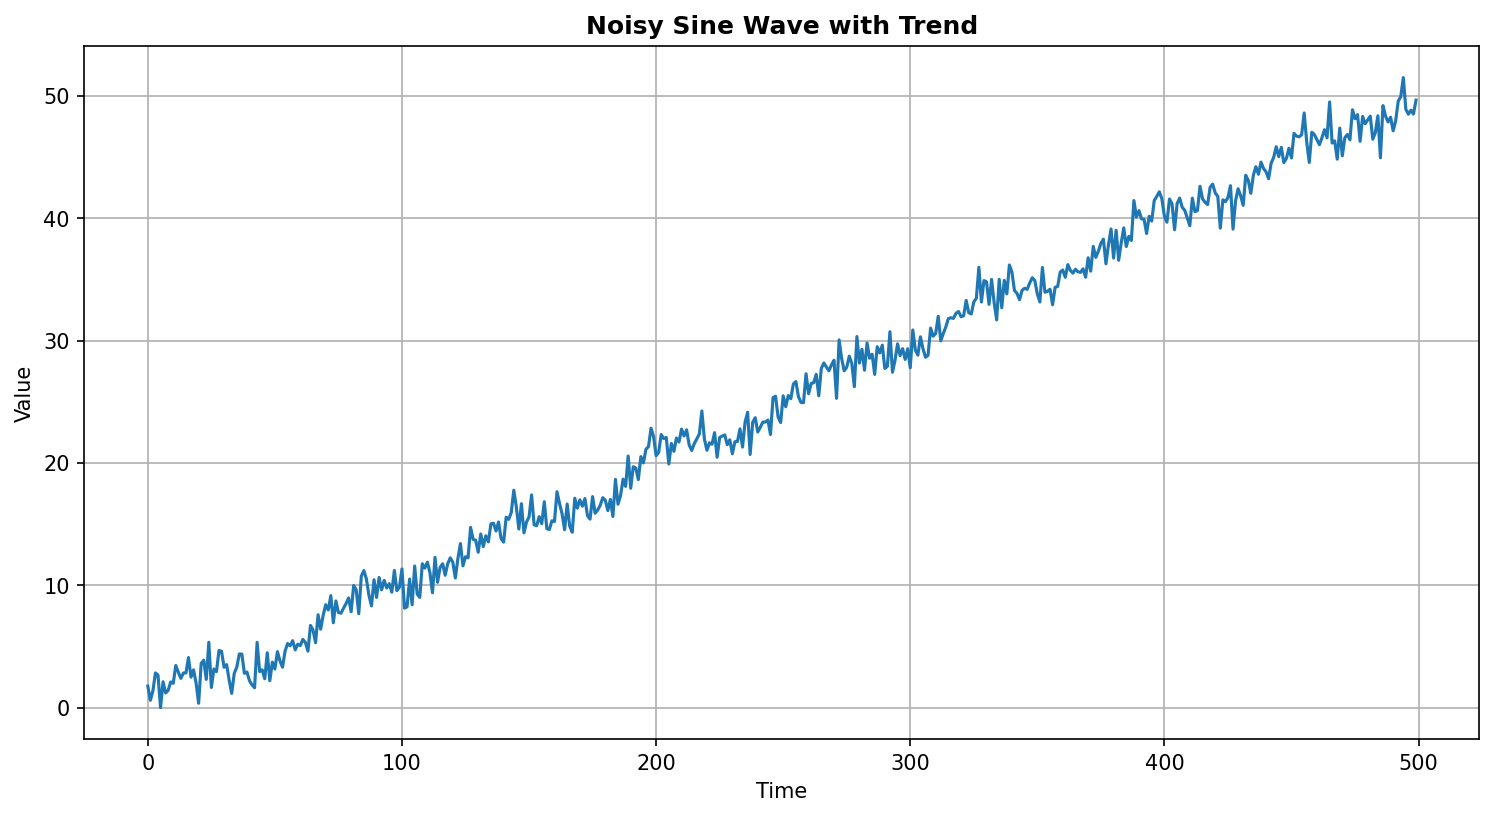

In [134]:
np.random.seed(0)
t = np.linspace(0, 50, 500)
data = np.sin(t)
data_original = data.copy()+t
z = np.random.normal(0,1,data.shape)
data+=z+t
plt.figure(figsize=(12, 6),dpi=150)
plt.plot(data)
plt.title('Noisy Sine Wave with Trend',fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()
plt.show()



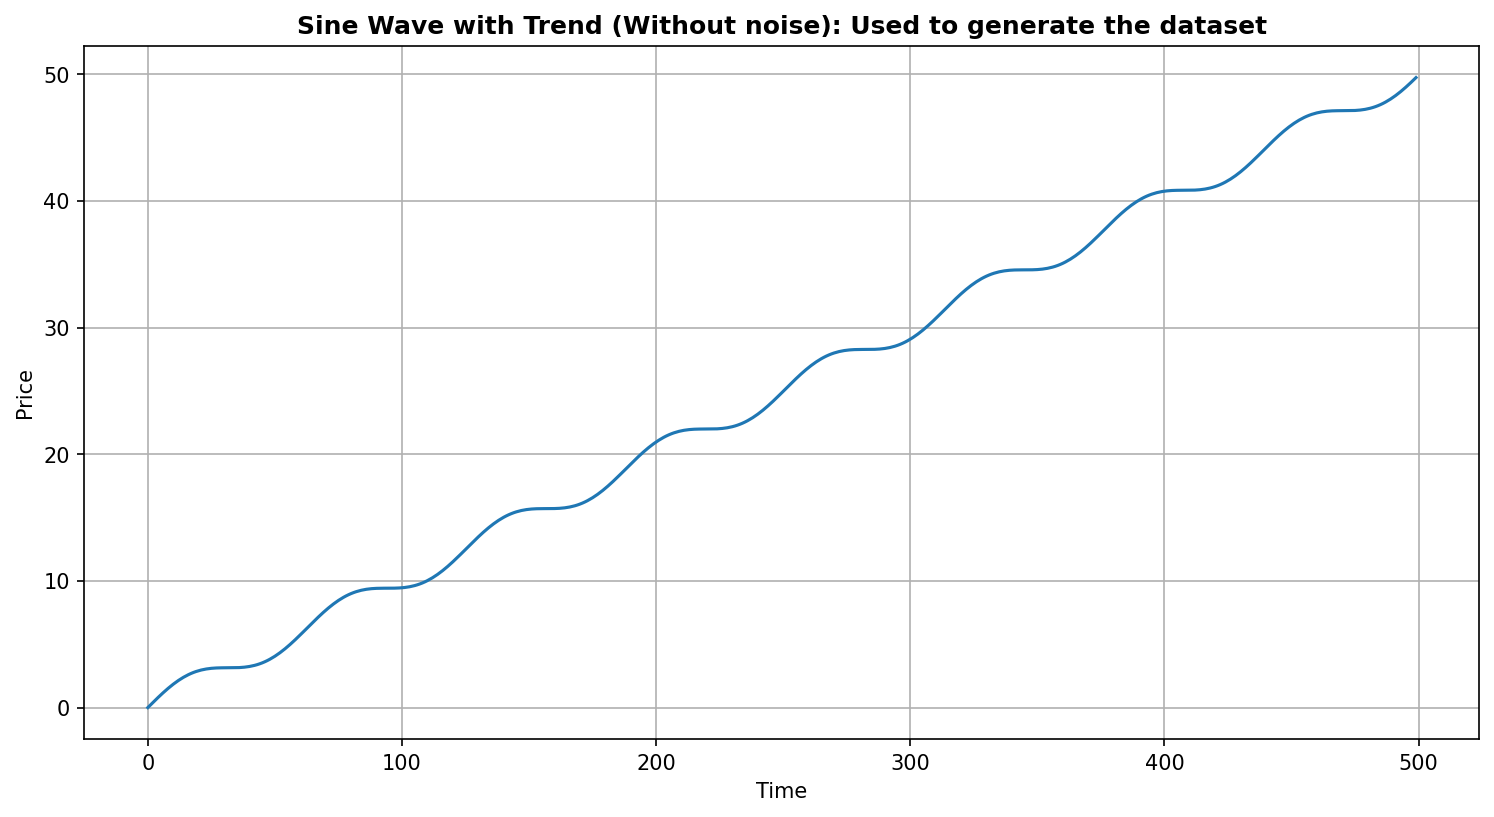

In [135]:
plt.figure(figsize=(12, 6),dpi=150)
plt.plot(data_original)
plt.title('Sine Wave with Trend (Without noise): Used to generate the dataset',fontweight='bold')
plt.xlabel('Time')
plt.grid()
plt.ylabel('Price')
plt.show()

In [136]:
df = pd.DataFrame({'y':data})
df.head(5)

,y
0,1.764052
1,0.600390
2,1.378201
3,2.837589
4,2.658516


In [137]:
def generate_data_split(df,ratio):
    training_size = int(np.floor(len(df)*ratio))
    df_train = df.iloc[:training_size].values
    df_test = df.iloc[training_size+1:].values
    
    #print("Training size"training_size)
    return df_train,df_test

In [138]:
df_train,df_test = generate_data_split(df,0.7)
scaler_df_train = StandardScaler()
scaler_df_test = StandardScaler()
df_train_scaled = scaler_df_train.fit_transform(df_train)
df_test_scaled = scaler_df_train.fit_transform(df_test)

In [8]:
'''ArithmeticError





plt.figure(figsize=(12, 6),dpi=200)
plt.plot(np.arange(0,len(df_train),1),df_train.flatten(),label='Train',color='blue')
plt.title('Noisy Sine Wave with Trend: Simulated Time-Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(350,len(df_test),1),df_test.flatten(),label='Test',color='navy')
plt.legend()

plt.show()


'''


"ArithmeticError\n\n\n\n\n\nplt.figure(figsize=(12, 6),dpi=200)\nplt.plot(np.arange(0,len(df_train),1),df_train.flatten(),label='Train',color='blue')\nplt.title('Noisy Sine Wave with Trend: Simulated Time-Series')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.plot(np.arange(350,len(df_test),1),df_test.flatten(),label='Test',color='navy')\nplt.legend()\n\nplt.show()\n\n\n"

In [140]:
def time_series_divide(df,samples=5):
    x_train = []
    y_train = []
    for i in range(len(df)-samples):
        x_train.append(df[i:i+samples])
        y_train.append(df[i+samples][0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    return x_train,y_train
samples=5
x_train,y_train = time_series_divide(df_train_scaled,samples)
x_test,y_test = time_series_divide(df_test_scaled,samples)

x_train.shape,y_train.reshape(-1,1).shape

((345, 5, 1), (345, 1))

Since we only have one feature (in our original dataset), x_train is a two dimensional tensor (matrix), so we can work with x_train as a matrix. This is useful because the math is simpler.

In [141]:
x_train = x_train[:,:,0]
x_test = x_test[:,:,0]

x_train.shape

(345, 5)

# RNN Structure


1. **Input-to-Hidden Weights (`$W_{xh}`)**:
   - Shape: \($ W_{xh} \in \mathbb{R}^{d_{\text{input}} \times d_{\text{hidden}}} $\)
   - \($ d_{\text{input}} $\): Dimensionality of the input vector \( $x_t $\).
   - \( $d_{\text{hidden}} $\): Dimensionality of the hidden state \( $h_t$ \).

2. **Hidden-to-Hidden Weights (`W_{hh}`)**:
   - Shape: \($ W_{hh} \in \mathbb{R}^{d_{\text{hidden}} \times d_{\text{hidden}}} $\)
   - \($ d_{\text{hidden}} $\): Dimensionality of the hidden state \( h_t \).

3. **Bias for Hidden State (`b_h`)**:
   - Shape: \($ b_h \in \mathbb{R}^{d_{\text{hidden}}}$ \)
   - \( $d_{\text{hidden}} $\): Dimensionality of the hidden state \( $h_t $\).

2. **Hidden-to-Output Weights (`W_{hh}`)**:
   - Shape: \($ W_{ho} \in \mathbb{R}^{d_{\text{hidden}} \times d_{\text{output}}} $\)
   - \($ d_{\text{hidden}} $\): Dimensionality of the hidden state \( h_t \).

In [ ]:
n_cells = 1
n_output = 1
n_features =5
w_i_h = np.random.uniform(0,0.15,size=(n_features,n_cells))
w_h_h = np.random.uniform(0,0.15,size=(n_cells,n_cells))
w_h_o = np.random.uniform(0, 0.15, size=(n_cells, n_output))
bias_hidden = np.random.uniform(0, 0.15, size=(n_cells, 1))
bias_output = np.random.uniform(0, 0.15, size=(n_output, 1))

print('Number of Hidden Cells:',n_cells)
print("\nShapes:")
print("w_i_h ('U' matrix):", w_i_h.shape)
print("w_h_h ('V' matrix):", w_h_h.shape)
print("w_h_o ('W' matrix):", w_h_o.shape)
print("bias_hidden:", bias_hidden.shape)
print("bias_output:", bias_output.shape)


Number of Hidden Cells: 1

Shapes:
w_i_h ('U' matrix): (5, 1)
w_h_h ('V' matrix): (1, 1)
w_h_o ('W' matrix): (1, 1)
bias_hidden: (1, 1)
bias_output: (1, 1)


In [159]:

def sum_squared_error(y_pred, y_true):
    return 0.5*(np.sum((y_pred - y_true) ** 2))
def identity(x):
    return x
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)
def activation_derivative(a_n,activation='sigmoid'):
     if (activation == 'sigmoid'):
        return a_n*(1-a_n)
     elif (activation == 'tanh'):
        return 1-(a_n)**2
     elif (activation=='identity'):
         return 1
     else:
         print('Only sigmoid is currently available, TO-DO other activations')
         return ValueError
def sse_loss_grad(y_pred, y_true):
    return (y_pred - y_true)

def clip_gradients(gradients, clip_value):
    return np.clip(gradients, -clip_value, clip_value)
def mse(y_pred, y_true):
    return (0.5*(np.sum((y_pred - y_true) ** 2)))/len(y_true)


# RNN For Regression

Hiperbolic Tangent was choosen arbitrarly. To keep the model simpler, I chose to include only one hidden cell. Since one should be more than enough for learning this dataset.

In [13]:
#My function is caled SimpleRNN in a tribute to TF's SimpleRNN.

def SimpleRNN(x_train,y_train,epochs,lr=0.0009,
    clip_value=100,
    activation = tanh,
    activation_output = identity,
    n_cells = 1,
    n_output = 1,
    n_features =5,):
    #RNN parameters 


    #data structures
    w_i_h = np.random.normal(0,1/365,size=(n_features,n_cells))
    w_h_h = np.random.normal(0,1/365,size=(n_cells,n_cells))
    w_h_o =np.random.normal(0, 1/365, size=(n_cells, n_output))
    bias_hidden = np.random.normal(0,1/365, size=(n_cells, 1))
    bias_output = np.random.normal(0, 1/365, size=(n_output, 1))
    activ_history = np.zeros(shape=(x_train.shape[0],n_cells))
    output_history = np.zeros(shape=(x_train.shape[0],n_cells))
    cell_error = np.zeros(shape=(y_train.shape[0],n_cells))
    #gradient ds
    print('Number of Hidden Cells:',n_cells)
    print("\nShapes:")
    print("w_i_h ('U' matrix):", w_i_h.shape)
    print("w_h_h ('V' matrix):", w_h_h.shape)
    print("w_h_o ('W' matrix):", w_h_o.shape)
    print("bias_hidden:", bias_hidden.shape)
    print("bias_output:", bias_output.shape)

    cell_error_history = []

    for epoch in range(epochs):
        cell_error = np.zeros(shape=(y_train.shape[0], 1))
        for i in range(len(x_train)):
            if (i == 0):
                x_1 = x_train[i]
                a_1 = activation(x_1@w_i_h+bias_hidden)
                activ_history[i] = a_1
                #adding output: first timestamp
                #null vector as `primer`
                y_1 = activation_output(a_1 @ w_h_o + bias_output)
                output_history[i] = y_1

                cell_error[i] = sum_squared_error(y_train[i],y_1)
            else:
                x_n = x_train[i]
                a_n = activation(x_n@w_i_h + w_h_h@activ_history[i-1] + bias_hidden)
                activ_history[i] = a_n

                y_n = activation_output(a_n@w_h_o+bias_output)
                output_history[i] = y_n
                cell_error[i] = sum_squared_error(y_train[i],y_n)
        delta_w_h_o = np.zeros_like(w_h_o)
        delta_bias_output = np.zeros_like(bias_output)
        delta_bias_hidden = np.zeros_like(bias_hidden)
        delta_w_i_h = np.zeros_like(w_i_h)
        delta_w_h_h = np.zeros_like(w_h_h)
        #output_bias_grad = np.zeros_like(bias_output)
        #input_bias_grad = np.zeros_like(bias_hidden)
        for j in reversed(range(len(x_train))):
            y_pred_j = output_history[j]
            y_train_j = y_train[j]
            x_train_j = x_train[j]
            a_n_j = activ_history[j]

            #using hadamard product, np.multiply or *, is wrong here!!
            #hadamard's ensure all interactions are accounted!
            output_error = y_pred_j - y_train_j
            delta_output = output_error * activation_derivative(y_n,'identity') 
            delta_hidden = (delta_output @ w_h_o.T) * activation_derivative(a_n_j,'tanh')

            delta_w_h_o += np.outer(a_n_j,(y_pred_j-y_train_j))
            delta_w_i_h += np.outer(x_train_j,delta_hidden)
            hidden_error = delta_output @ w_h_o.T
            delta_bias_output += (y_pred_j-y_train_j)
            delta_bias_hidden += delta_hidden
            if j > 0:
                delta_w_h_h += np.outer(a_n_j, delta_hidden)
                hidden_error = delta_hidden @ w_h_h.T
                for t in range(j - 1, -1, -1):
                    delta_hidden = hidden_error * (1 - activ_history[t] ** 2)
                    delta_w_i_h += np.outer(x_train[t], delta_hidden)
                    delta_bias_hidden += delta_hidden
                    delta_w_h_h += np.outer(activ_history[t - 1], delta_hidden) if t > 0 else 0
                    hidden_error = delta_hidden @ w_h_h.T
        w_h_o -= lr * clip_gradients(delta_w_h_o, clip_value)
        w_i_h -= lr * clip_gradients(delta_w_i_h, clip_value)
        w_h_h -= lr * clip_gradients(delta_w_h_h, clip_value)
        bias_output -= lr * clip_gradients(delta_bias_output, clip_value)
        bias_hidden -= lr * clip_gradients(delta_bias_hidden, clip_value)
        epoch_total_error = np.sum(cell_error)
        mse = np.sum(cell_error) / len(y_train)
        cell_error_history.append(mse)
        print(f'Epoch {epoch} / {epochs}: \nSSE: {epoch_total_error}| Mean Squared Error: {mse}\n')
    return w_i_h, w_h_h, w_h_o, bias_hidden, bias_output, cell_error_history

In [14]:

w_i_h, w_h_h, w_h_o, bias_hidden, bias_output, cell_error_history = SimpleRNN(np.array(x_train), np.array(y_train), 1000, lr=0.0009,clip_value=150)


Number of Hidden Cells: 1

Shapes:
w_i_h ('U' matrix): (5, 1)
w_h_h ('V' matrix): (1, 1)
w_h_o ('W' matrix): (1, 1)
bias_hidden: (1, 1)
bias_output: (1, 1)
Epoch 0 / 1000: 
SSE: 168.96305990469764| Mean Squared Error: 0.48974799972376126

Epoch 1 / 1000: 
SSE: 168.88944056581067| Mean Squared Error: 0.48953461033568313

Epoch 2 / 1000: 
SSE: 168.81728752853667| Mean Squared Error: 0.48932547109720775

Epoch 3 / 1000: 
SSE: 168.67967564535962| Mean Squared Error: 0.48892659607350614

Epoch 4 / 1000: 
SSE: 168.32792019425574| Mean Squared Error: 0.48790701505581374

Epoch 5 / 1000: 
SSE: 167.37417434931945| Mean Squared Error: 0.48514253434585347

Epoch 6 / 1000: 
SSE: 164.81251708862786| Mean Squared Error: 0.4777174408366025

Epoch 7 / 1000: 
SSE: 158.29596770760412| Mean Squared Error: 0.4588288919060989

Epoch 8 / 1000: 
SSE: 143.79313064479064| Mean Squared Error: 0.41679168302837866

Epoch 9 / 1000: 
SSE: 118.88743922862483| Mean Squared Error: 0.3446012731264488

Epoch 10 / 1000: 

In [ ]:
params = {
    'w_i_h': w_i_h,
    'w_h_h': w_h_h,
    'w_h_o': w_h_o,
    'bias_hidden': bias_hidden,
    'bias_output': bias_output,
    'cell_error_history':cell_error_history
}

with open('RNN_Parameters.pkl', 'wb') as file:
    pkl.dump(params, file)

In [ ]:
with open('RNN_Parameters.pkl', 'rb') as file:
    params = pkl.load(file)

cell_error_history = params['cell_error_history']
w_i_h = params['w_i_h']
w_h_h = params['w_h_h']
w_h_o = params['w_h_o']
bias_hidden = params['bias_hidden']
bias_output = params['bias_output']

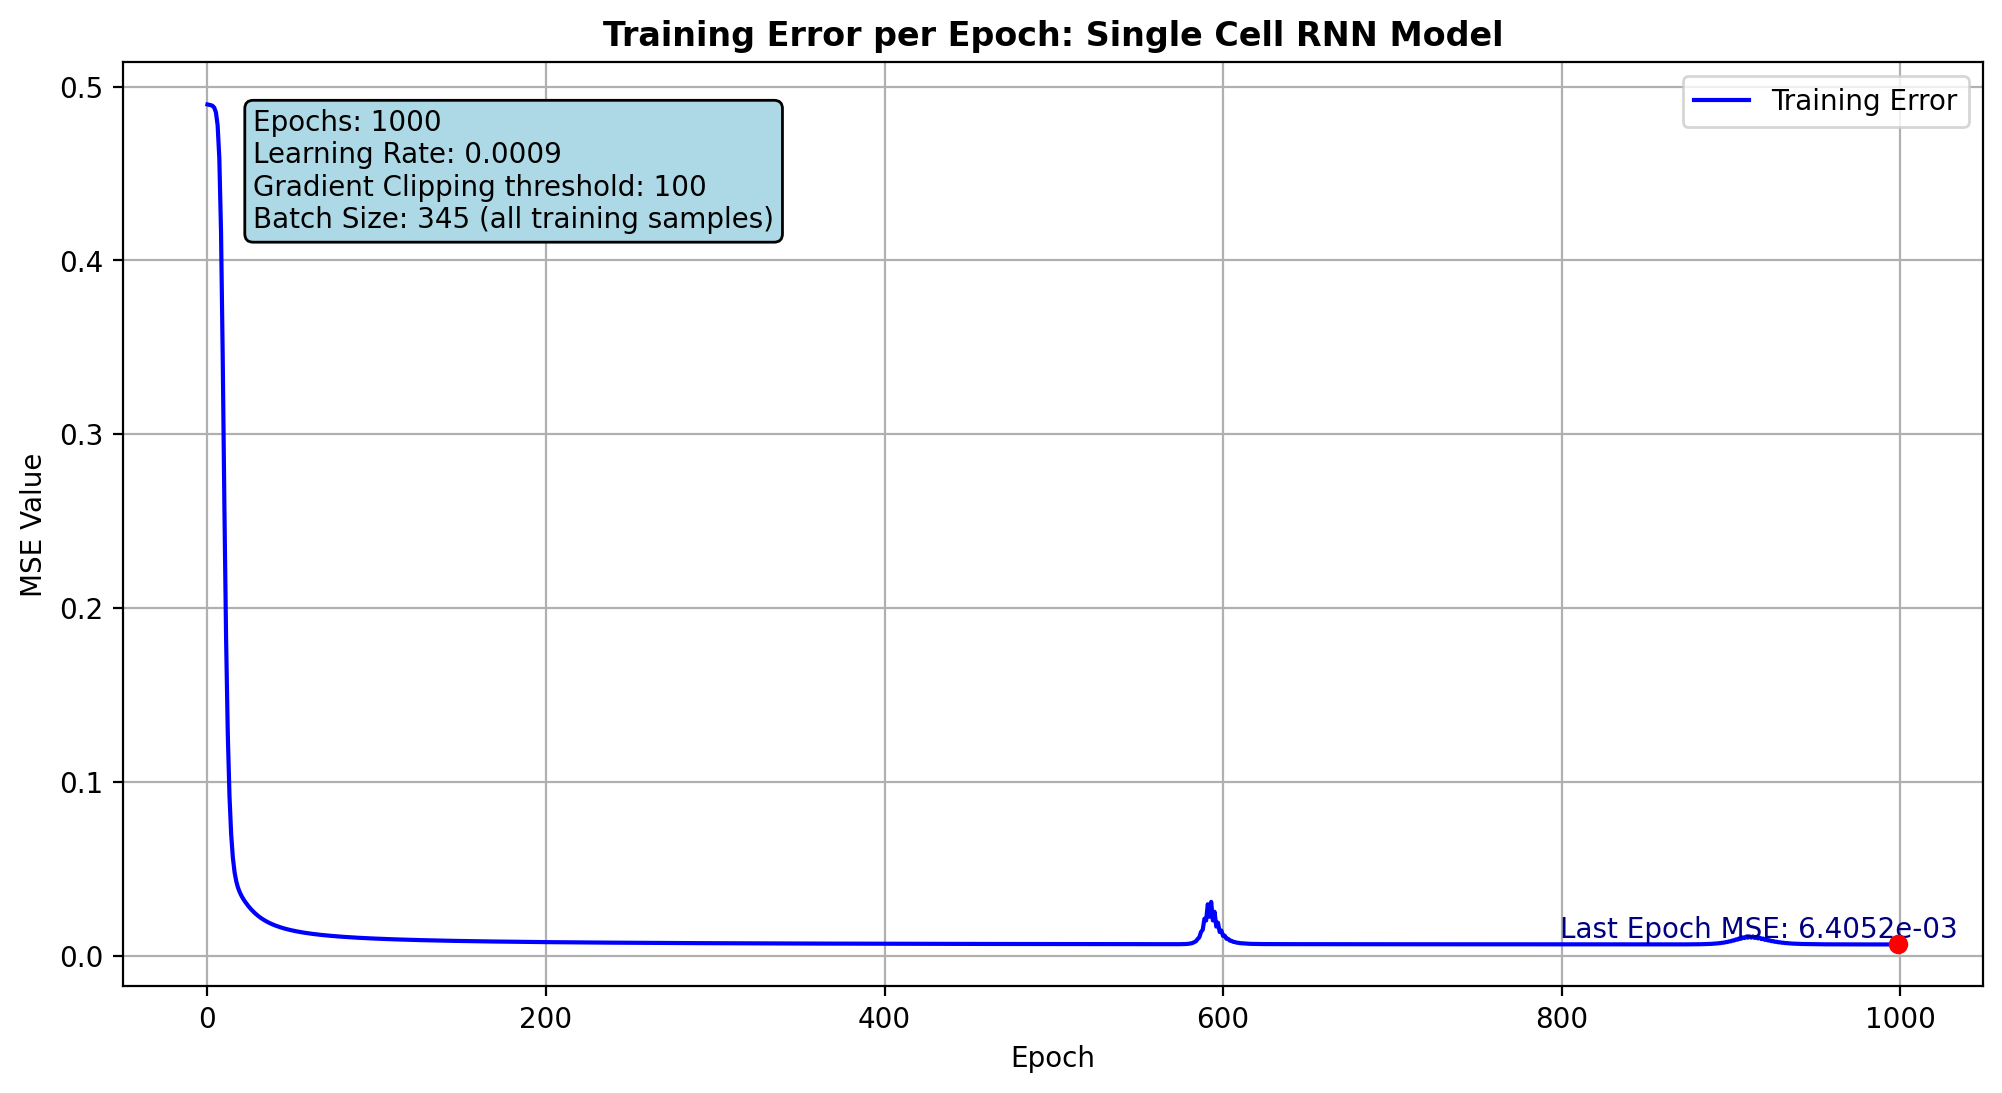

In [15]:
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(cell_error_history, label='Training Error',color='Blue')

# Highlight the last point
last_point = cell_error_history[-1]
last_index = len(cell_error_history) - 1
plt.scatter([last_index], [last_point], color='red', zorder=5)  # Highlight the last point with a red star
plt.annotate(f'Last Epoch MSE: {last_point:.4e}',
             xy=(last_index, 0.02),
             xytext=(last_index-200, 0.01),color='navy'
            )

# Add title and labels
plt.title('Training Error per Epoch: Single Cell RNN Model',loc='center',fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Value')
plt.legend()
epochs = 1000
learning_rate = 0.0009
clip_value = 100
info_text = (f"Epochs: {epochs}\n"
             f"Learning Rate: {learning_rate}\n"
             f"Gradient Clipping threshold: {clip_value}\n"
             f"Batch Size: {x_train.shape[0]} (all training samples)")
plt.text(0.07, 0.95, info_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightblue'),color='black')
plt.grid()

plt.show()


In [16]:
def SimpleRNNPredict(x_train,w_i_h, w_h_h, w_h_o, bias_hidden, bias_output):
    #RNN parameters 
    activation = tanh
    activation_output = identity
    n_cells = 1

    #data structures
    activ_history = np.zeros(shape=(x_train.shape[0],n_cells))
    output_history = np.zeros(shape=(x_train.shape[0],n_cells))
    #gradient ds


    for i in range(len(x_train)):
        if (i == 0):
            x_1 = x_train[i]
            a_1 = activation(x_1@w_i_h+bias_hidden)
            activ_history[i] = a_1
            #adding output: first timestamp
            #null vector as `primer`
            y_1 = activation_output(a_1 @ w_h_o + bias_output)
            output_history[i] = y_1

        else:
            x_n = x_train[i]
            a_n = activation(x_n@w_i_h + w_h_h@activ_history[i-1] + bias_hidden)
            activ_history[i] = a_n

            y_n = activation_output(a_n@w_h_o+bias_output)
            output_history[i] = y_n
        
    return output_history
    

y_train_pred = SimpleRNNPredict(x_train,w_i_h, w_h_h, w_h_o, bias_hidden, bias_output)


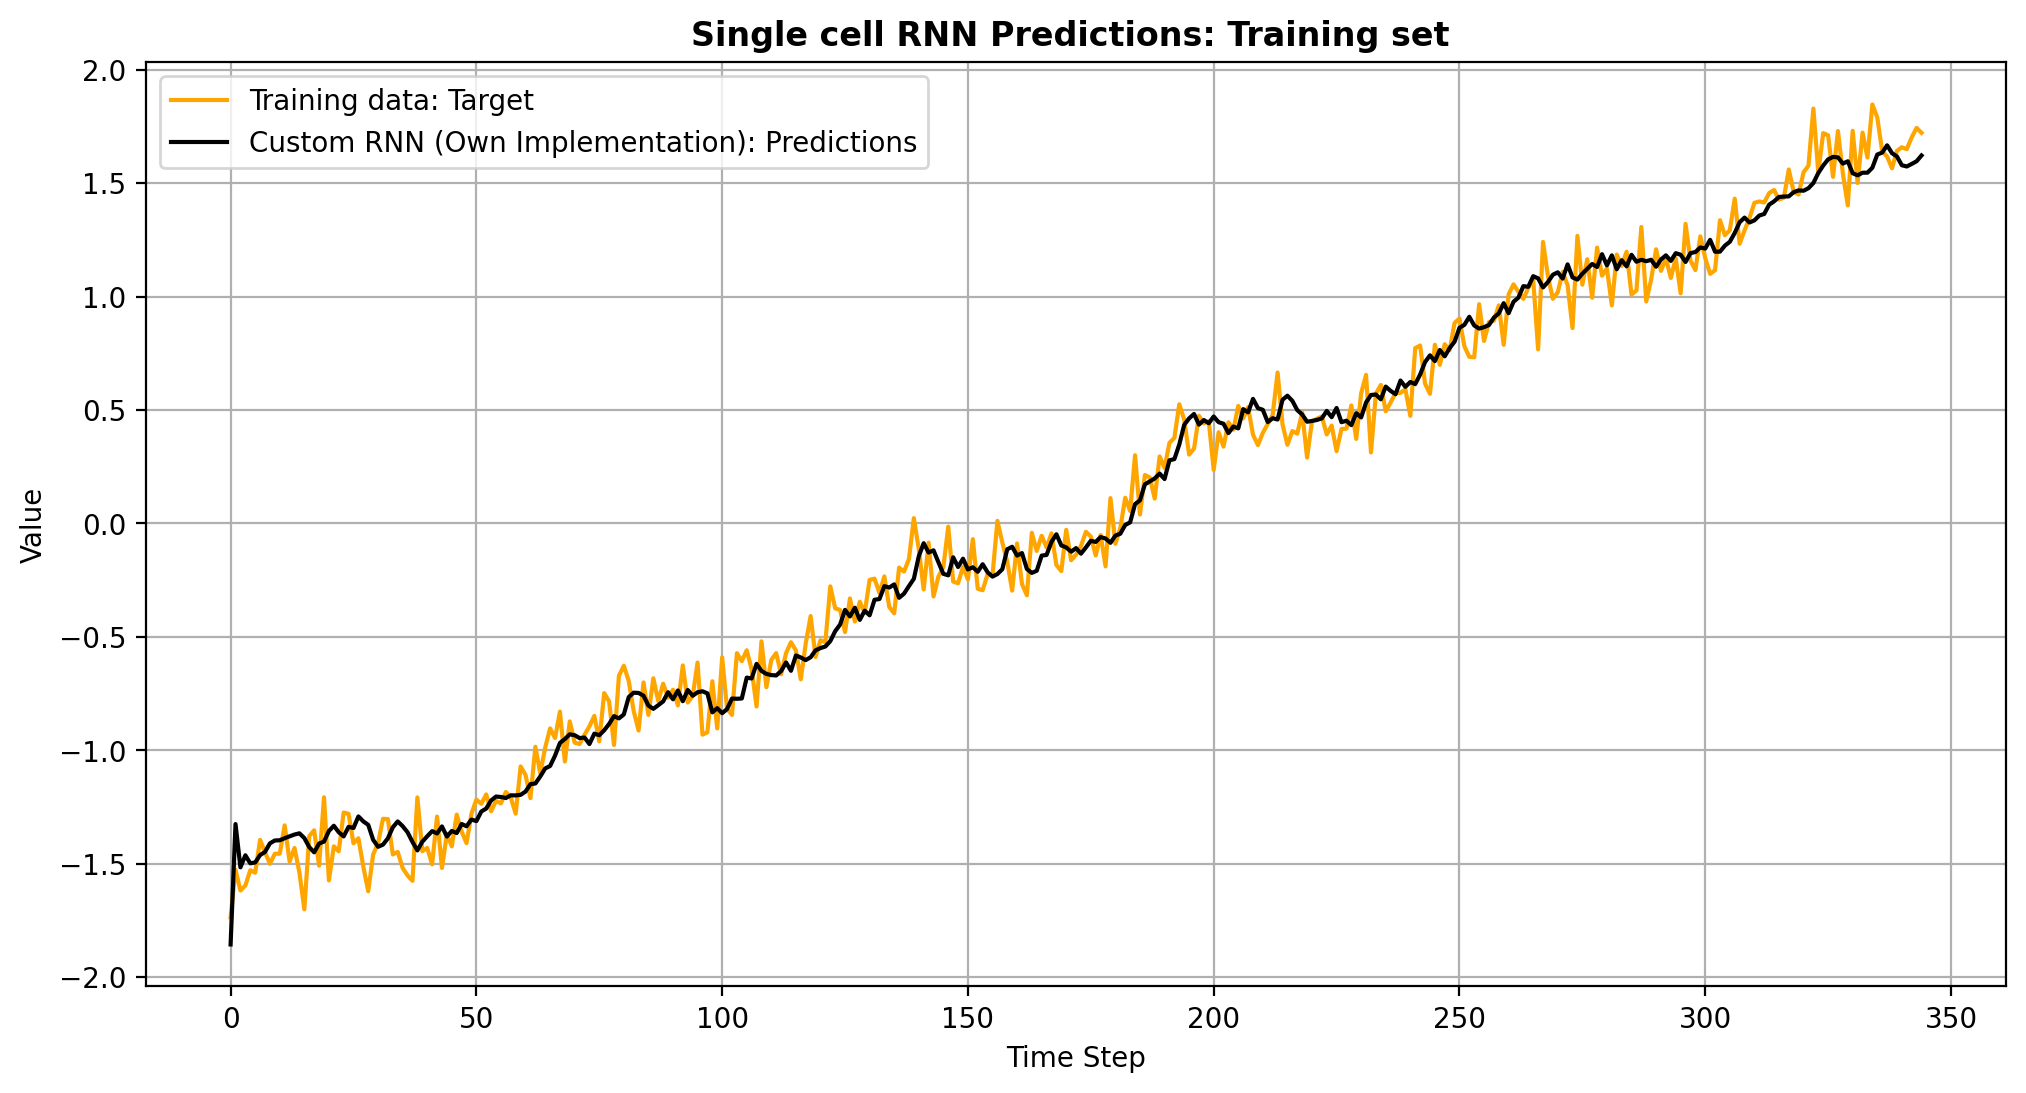

In [17]:
plt.figure(figsize=(12, 6),dpi=200)
plt.plot(y_train,label='Training data: Target',color='orange')
plt.plot(y_train_pred,label='Custom RNN (Own Implementation): Predictions',color='black')
plt.grid()
plt.legend()
plt.title('Single cell RNN Predictions: Training set ',loc='center',fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential(name='single_cell_rnn')

model.add(SimpleRNN(units=1, input_shape=(5,1)))

model.add(Dense(units=1))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0009)
model.compile(loss='mean_squared_error',optimizer=optimizer)
model.summary()
model.fit(x_train,y_train,epochs=1000,batch_size=1)



Model: "single_cell_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
345/345 [==============================] - 1s 707us/step - loss: 0.2533
Epoch 2/1000
345/345 [==============================] - 0s 628us/step - loss: 0.1764
Epoch 3/1000
345/345 [==============================] - 0s 717us/step - loss: 0.1427
Epoch 4/1000
345/345 [==============================] - 0s 617us/step - loss: 0.1259
Epoch 5/1000
345/345 [==============================] - 0s 612us/step - los

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential(name='single_cell_rnn')

model.add(SimpleRNN(units=1, input_shape=(5,1)))

model.add(Dense(units=1))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0009)
model.compile(loss='mean_squared_error',optimizer=optimizer)
model.summary()
model.fit(x_train,y_train,epochs=1000,batch_size=1)

In [20]:
y_tf_pred = model.predict(x_train)

11/11 [==============================] - 0s 675us/step


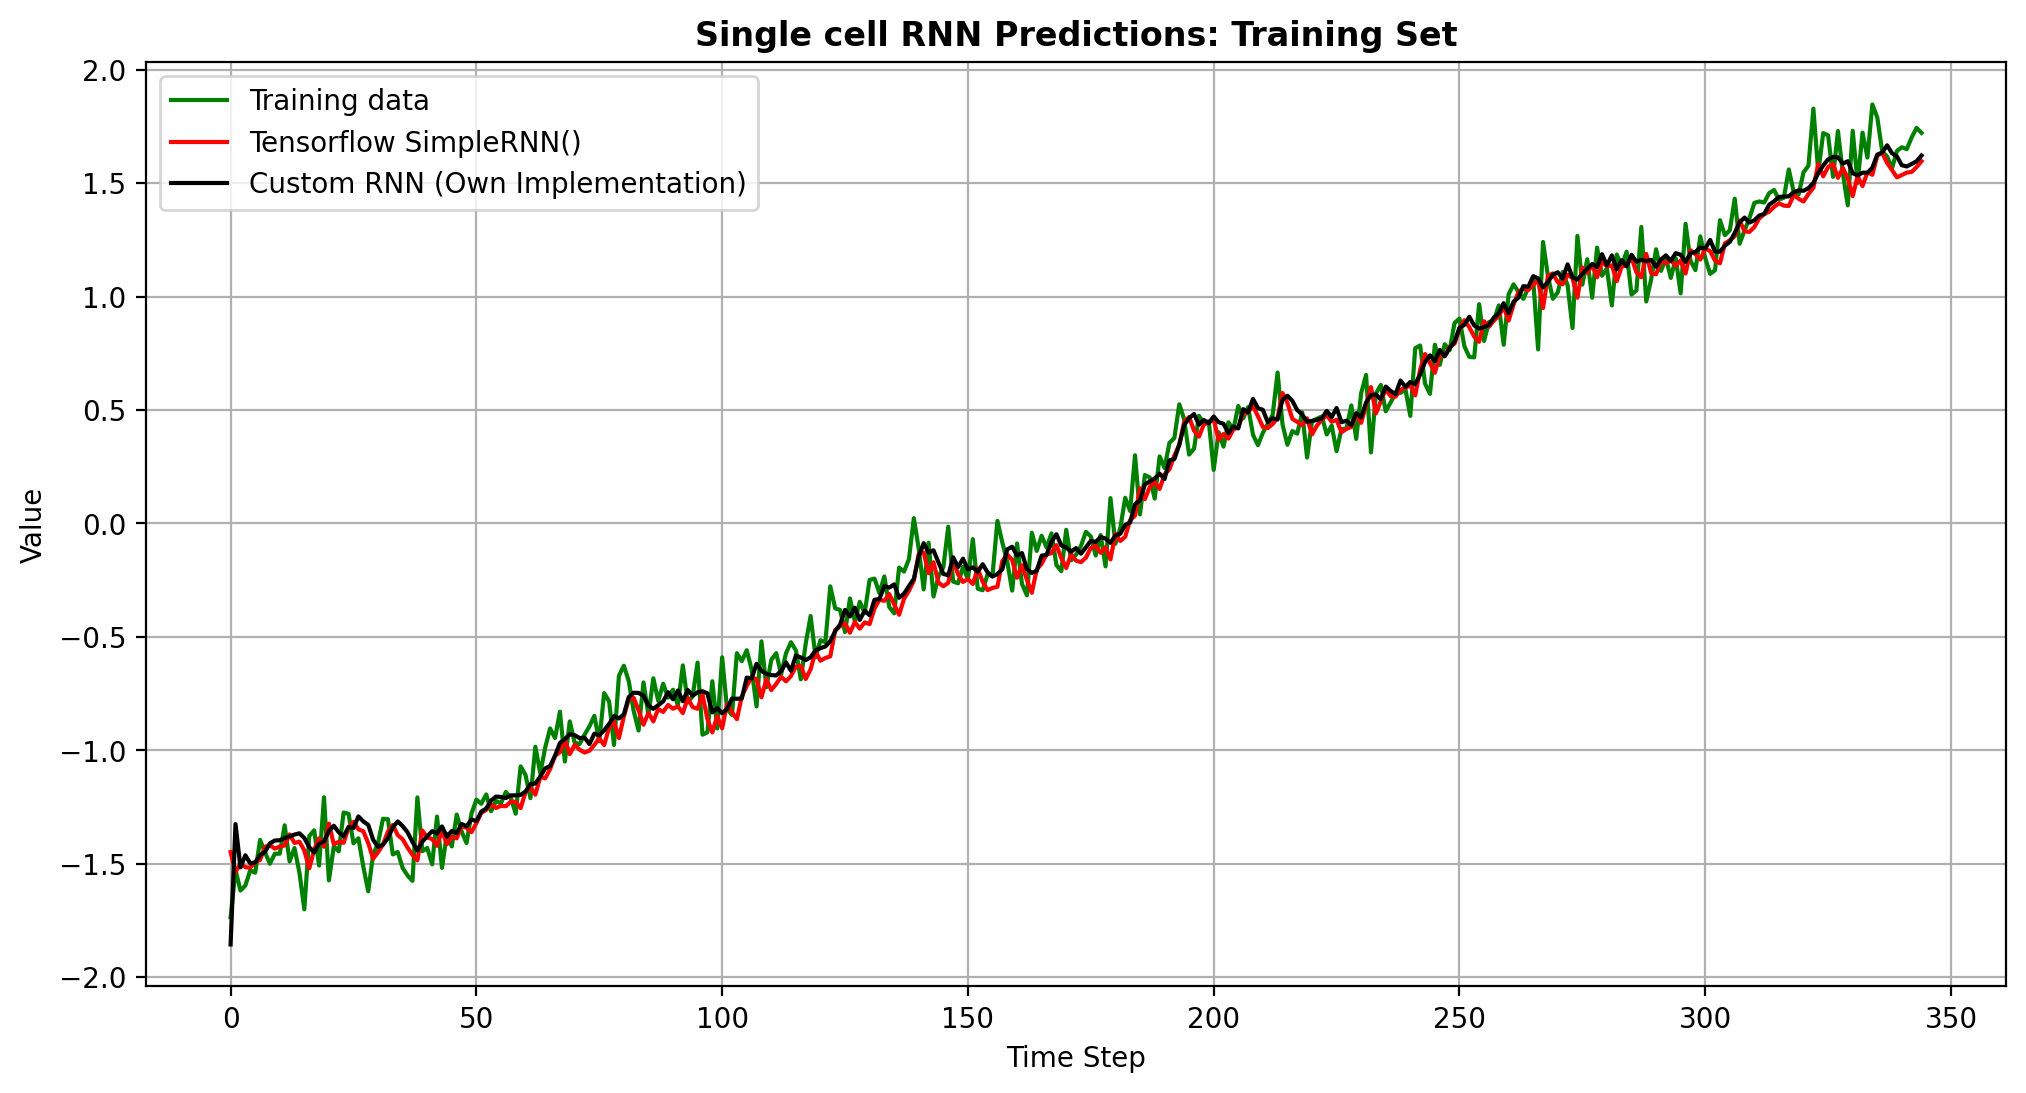

In [21]:
plt.figure(figsize=(12, 6),dpi=200)
plt.plot(y_train,label='Training data',color='green')

plt.plot(y_tf_pred,label='Tensorflow SimpleRNN()',color='red')
plt.plot(y_train_pred,label='Custom RNN (Own Implementation)',color='black')
plt.legend()
plt.title('Single cell RNN Predictions: Training Set',fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid()
plt.show()

In [22]:
y_test_pred = SimpleRNNPredict(x_test,w_i_h, w_h_h, w_h_o, bias_hidden, bias_output)
y_tf_test_pred = model.predict(x_test)


5/5 [==============================] - 0s 968us/step


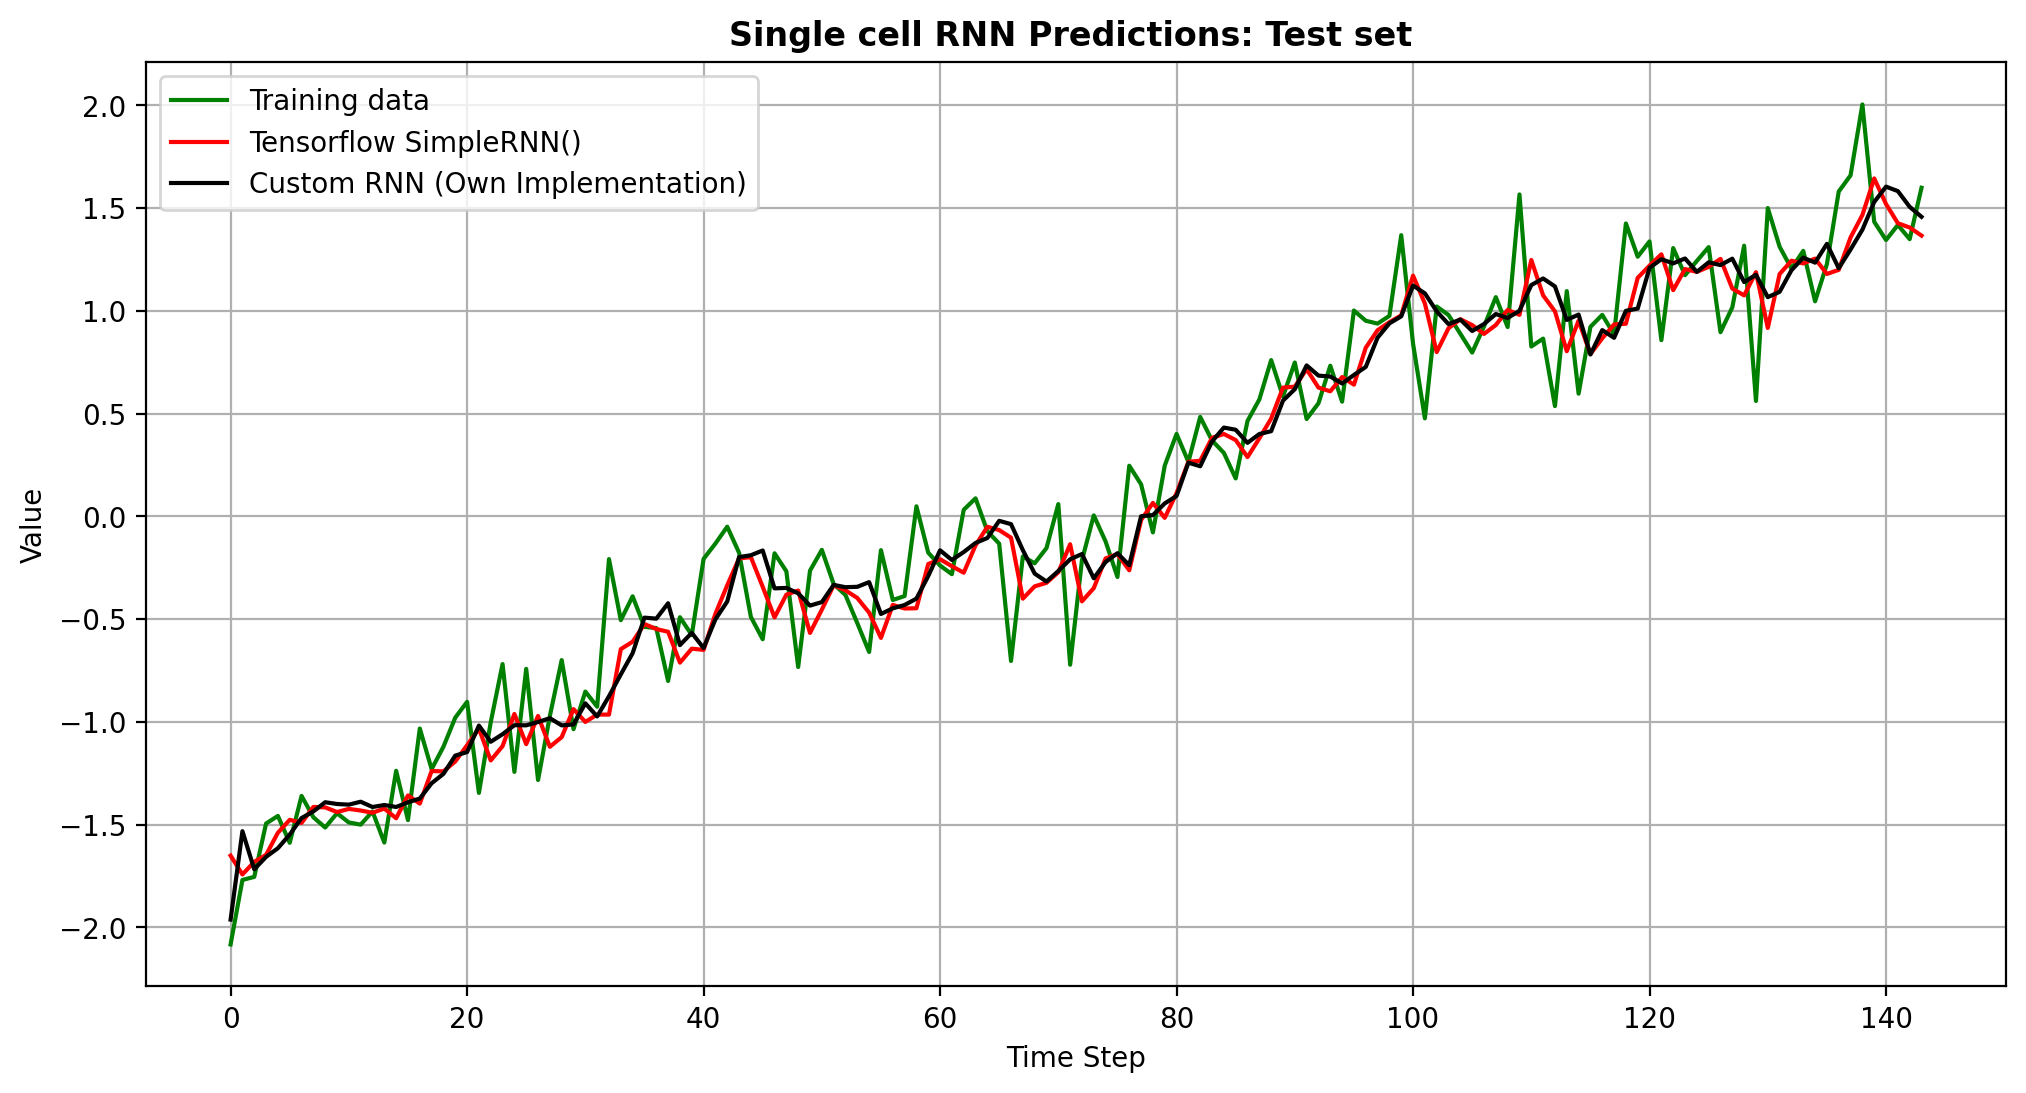

In [24]:
plt.figure(figsize=(12, 6),dpi=200)
plt.plot(y_test,label='Training data',color='green')
plt.plot(y_tf_test_pred,label='Tensorflow SimpleRNN()',color='red')
plt.plot(y_test_pred,label='Custom RNN (Own Implementation)',color='black')

plt.legend()
plt.title('Single cell RNN Predictions: Test set ',loc='center',fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid()
plt.show()

In [198]:
def naive_ts(x_test):
    predictions = []
    for i in range(len(x_test)):
        predictions.append(x_test[i,-1])
    return predictions

y_naive_pred = naive_ts(x_test)

print("Naive Approach (Not a model) MSE: ",mse(y_naive_pred, y_test))
print("SimpleRNN() TensorFlow MSE: ",mse(y_tf_test_pred, y_test))
print("Own implementation MSE: ",mse(y_test_pred, y_test))


Naive model MSE:  0.04699122090812305
SimpleRNN() TensorFlow MSE:  130.9407643836146
Own implementation MSE:  131.1365071368544
